In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define METAINFO
METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt/concrete",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush/shrub",
        "fence",
        "other-structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0, 0, 0),
        (230, 25, 75),
        (60, 180, 75),
        (255, 225, 25),
        (0, 130, 200),
        (145, 30, 180),
        (70, 240, 240),
        (240, 50, 230),
        (210, 245, 60),
        (250, 190, 190),
        (0, 128, 128),
        (170, 110, 40),
        (255, 250, 200),
        (128, 0, 0),
        (170, 255, 195),
        (128, 128, 0),
        (255, 215, 180),
        (0, 0, 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

In [2]:
class SegNet(nn.Module):
    def __init__(self, num_classes=19):
        super(SegNet, self).__init__()

        # Encoder
        self.encoder_conv_00 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.encoder_bn_00 = nn.BatchNorm2d(64)
        self.encoder_conv_01 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.encoder_bn_01 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.encoder_conv_10 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.encoder_bn_10 = nn.BatchNorm2d(128)
        self.encoder_conv_11 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.encoder_bn_11 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.encoder_conv_20 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.encoder_bn_20 = nn.BatchNorm2d(256)
        self.encoder_conv_21 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.encoder_bn_21 = nn.BatchNorm2d(256)
        self.encoder_conv_22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.encoder_bn_22 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.encoder_conv_30 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.encoder_bn_30 = nn.BatchNorm2d(512)
        self.encoder_conv_31 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.encoder_bn_31 = nn.BatchNorm2d(512)
        self.encoder_conv_32 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.encoder_bn_32 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        
        self.encoder_conv_40 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.encoder_bn_40 = nn.BatchNorm2d(512)
        self.encoder_conv_41 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.encoder_bn_41 = nn.BatchNorm2d(512)
        self.encoder_conv_42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.encoder_bn_42 = nn.BatchNorm2d(512)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # Decoder
        self.unpool5 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_conv_42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.decoder_bn_42 = nn.BatchNorm2d(512)
        self.decoder_conv_41 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.decoder_bn_41 = nn.BatchNorm2d(512)
        self.decoder_conv_40 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.decoder_bn_40 = nn.BatchNorm2d(512)
        
        self.unpool4 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_conv_32 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.decoder_bn_32 = nn.BatchNorm2d(512)
        self.decoder_conv_31 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.decoder_bn_31 = nn.BatchNorm2d(512)
        self.decoder_conv_30 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.decoder_bn_30 = nn.BatchNorm2d(256)
        
        self.unpool3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_conv_22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.decoder_bn_22 = nn.BatchNorm2d(256)
        self.decoder_conv_21 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.decoder_bn_21 = nn.BatchNorm2d(256)
        self.decoder_conv_20 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.decoder_bn_20 = nn.BatchNorm2d(128)
        
        self.unpool2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_conv_11 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.decoder_bn_11 = nn.BatchNorm2d(128)
        self.decoder_conv_10 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.decoder_bn_10 = nn.BatchNorm2d(64)
        
        self.unpool1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.decoder_conv_01 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.decoder_bn_01 = nn.BatchNorm2d(64)
        self.decoder_conv_00 = nn.Conv2d(64, num_classes, kernel_size=3, padding=1)

    def forward(self, x):
        sizes = []
        indices = []
        
        # Encoder
        x = F.relu(self.encoder_bn_00(self.encoder_conv_00(x)))
        x = F.relu(self.encoder_bn_01(self.encoder_conv_01(x)))
        sizes.append(x.size())
        x, ind = self.pool1(x)
        indices.append(ind)

        x = F.relu(self.encoder_bn_10(self.encoder_conv_10(x)))
        x = F.relu(self.encoder_bn_11(self.encoder_conv_11(x)))
        sizes.append(x.size())
        x, ind = self.pool2(x)
        indices.append(ind)

        x = F.relu(self.encoder_bn_20(self.encoder_conv_20(x)))
        x = F.relu(self.encoder_bn_21(self.encoder_conv_21(x)))
        x = F.relu(self.encoder_bn_22(self.encoder_conv_22(x)))
        sizes.append(x.size())
        x, ind = self.pool3(x)
        indices.append(ind)

        x = F.relu(self.encoder_bn_30(self.encoder_conv_30(x)))
        x = F.relu(self.encoder_bn_31(self.encoder_conv_31(x)))
        x = F.relu(self.encoder_bn_32(self.encoder_conv_32(x)))
        sizes.append(x.size())
        x, ind = self.pool4(x)
        indices.append(ind)

        x = F.relu(self.encoder_bn_40(self.encoder_conv_40(x)))
        x = F.relu(self.encoder_bn_41(self.encoder_conv_41(x)))
        x = F.relu(self.encoder_bn_42(self.encoder_conv_42(x)))
        sizes.append(x.size())
        x, ind = self.pool5(x)
        indices.append(ind)
        
        # Decoder
        x = self.unpool5(x, indices.pop(), output_size=sizes.pop())
        x = F.relu(self.decoder_bn_42(self.decoder_conv_42(x)))
        x = F.relu(self.decoder_bn_41(self.decoder_conv_41(x)))
        x = F.relu(self.decoder_bn_40(self.decoder_conv_40(x)))

        x = self.unpool4(x, indices.pop(), output_size=sizes.pop())
        x = F.relu(self.decoder_bn_32(self.decoder_conv_32(x)))
        x = F.relu(self.decoder_bn_31(self.decoder_conv_31(x)))
        x = F.relu(self.decoder_bn_30(self.decoder_conv_30(x)))

        x = self.unpool3(x, indices.pop(), output_size=sizes.pop())
        x = F.relu(self.decoder_bn_22(self.decoder_conv_22(x)))
        x = F.relu(self.decoder_bn_21(self.decoder_conv_21(x)))
        x = F.relu(self.decoder_bn_20(self.decoder_conv_20(x)))

        x = self.unpool2(x, indices.pop(), output_size=sizes.pop())
        x = F.relu(self.decoder_bn_11(self.decoder_conv_11(x)))
        x = F.relu(self.decoder_bn_10(self.decoder_conv_10(x)))

        x = self.unpool1(x, indices.pop(), output_size=sizes.pop())
        x = F.relu(self.decoder_bn_01(self.decoder_conv_01(x)))
        x = self.decoder_conv_00(x)
        
        return x

In [3]:
class SegmentationDataset(Dataset):
    def __init__(self, csv_file, img_size=256, transform=None, subset_fraction=1, seed=42):
        self.data = pd.read_csv(csv_file)
        
        np.random.seed(seed)
        self.data = self.data.sample(frac=subset_fraction).reset_index(drop=True)
        
        self.img_size = img_size
        self.transform = transform
        self.label_transform = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        label_path = self.data.iloc[idx, 2]
        
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        label = Image.open(label_path).convert('L')
        label = self.label_transform(label)
        label = torch.tensor(np.array(label), dtype=torch.long)
        
        return {'image': image, 'label': label}

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

train_dataset = SegmentationDataset('splits/train.csv', subset_fraction = 0.3, transform=image_transform)
val_dataset = SegmentationDataset('splits/val.csv', transform=image_transform)
test_dataset = SegmentationDataset('splits/test.csv', transform=image_transform)

# in colab environment, the batch size can be increased to 32, maybe 64, we are running locally with batch size 4
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [4]:
def compute_class_iou(pred, target, num_classes):
    ious = np.zeros(num_classes)
    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls
        intersection = (pred_inds & target_inds).sum().item()
        union = pred_inds.sum().item() + target_inds.sum().item() - intersection
        if union != 0:
            ious[cls] = intersection / union
    return ious

def compute_mean_iou(ious):
    valid_ious = ious[ious > 0]
    if len(valid_ious) > 0:
        return valid_ious.mean()
    return 0.0

def train(model, loader, optimizer, device):
    model.train()
    total_ious = np.zeros(19)
    progress_bar = tqdm(loader, desc="Training")
    for data in progress_bar:
        images = data['image'].to(device)
        labels = data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
        preds = outputs.argmax(dim=1)
        ious = compute_class_iou(preds, labels, num_classes=19)
        total_ious += ious
        mean_iou = compute_mean_iou(ious)
        progress_bar.set_postfix(mean_iou=mean_iou)
    return total_ious / len(loader)

def validate(model, loader, device):
    model.eval()
    total_ious = np.zeros(19)
    progress_bar = tqdm(loader, desc="Validation")
    with torch.no_grad():
        for data in progress_bar:
            images = data['image'].to(device)
            labels = data['label'].to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            ious = compute_class_iou(preds, labels, num_classes=19)
            total_ious += ious
            mean_iou = compute_mean_iou(ious)
            progress_bar.set_postfix(mean_iou=mean_iou)
    return total_ious / len(loader)

In [5]:
# Hyperparameter grid
param_grid = {
    'learning_rate': [1e-4]
}

best_val_iou = float('-inf')
best_params = None

for params in ParameterGrid(param_grid):
    print(f"Training with params: {params}")
    
    model = SegNet(num_classes=19).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    
    for epoch in range(10):
        print(f"Epoch {epoch+1}/10")
        train_ious = train(model, train_loader, optimizer, device)
        val_ious = validate(model, val_loader, device)
        mean_train_iou = compute_mean_iou(train_ious)
        mean_val_iou = compute_mean_iou(val_ious)
        print(f"Epoch {epoch+1}, Train IoU: {mean_train_iou}, Val IoU: {mean_val_iou}")
        
        if mean_val_iou > best_val_iou:
            best_val_iou = mean_val_iou
            best_params = params

print(f"Best Params: {best_params}, Best Validation IoU: {best_val_iou}")

# Merge classes and print IoUs
def merge_and_print_ious(class_ious, classes):
    merged_classes = []
    merged_ious = []

    for idx, class_name in enumerate(classes):
        if class_name == "pole":
            # Merge pole IoU into other-object
            other_object_idx = classes.index("other-object")
            class_ious[other_object_idx] += class_ious[idx]
        elif class_name == "asphalt/concrete":
            # Merge asphalt IoU into other-terrain
            other_terrain_idx = classes.index("other-terrain")
            class_ious[other_terrain_idx] += class_ious[idx]
        elif class_name not in ["vehicle", "pole", "asphalt/concrete", "unlabelled"]:
            merged_classes.append(class_name)
            merged_ious.append(class_ious[idx])

    class_iou_pairs = list(zip(merged_classes, merged_ious))
    sorted_class_iou_pairs = sorted(class_iou_pairs, key=lambda x: x[0])

    for class_name, iou in sorted_class_iou_pairs:
        print(f"Class {class_name} IoU: {iou * 100: .2f}")

    MIou = np.nanmean(merged_ious)
    print(f"Mean IoU: {MIou * 100: .2f}")

# Assuming you have the IoUs from the validation step
merge_and_print_ious(val_ious, METAINFO['classes'])

Training with params: {'learning_rate': 0.0001}
Epoch 1/10


Validation: 100%|██████████| 71/71 [00:31<00:00,  2.25it/s, mean_iou=0.426]


Epoch 1, Train IoU: 0.13048956760639183, Val IoU: 0.43684741185723786
Epoch 2/10


Validation: 100%|██████████| 71/71 [00:32<00:00,  2.16it/s, mean_iou=0.485]


Epoch 2, Train IoU: 0.5089258507449623, Val IoU: 0.502658426928252
Epoch 3/10


Validation: 100%|██████████| 71/71 [00:33<00:00,  2.15it/s, mean_iou=0.42] 


Epoch 3, Train IoU: 0.5259231900874235, Val IoU: 0.4240697414980771
Epoch 4/10


Validation: 100%|██████████| 71/71 [00:33<00:00,  2.15it/s, mean_iou=0.519]


Epoch 4, Train IoU: 0.5321281096876365, Val IoU: 0.4976414419295308
Epoch 5/10


Validation: 100%|██████████| 71/71 [00:33<00:00,  2.12it/s, mean_iou=0.472]


Epoch 5, Train IoU: 0.5589280793024554, Val IoU: 0.4537790545176447
Epoch 6/10


Validation: 100%|██████████| 71/71 [00:34<00:00,  2.08it/s, mean_iou=0.464]


Epoch 6, Train IoU: 0.5611596092326057, Val IoU: 0.49998370630867706
Epoch 7/10


Validation: 100%|██████████| 71/71 [00:33<00:00,  2.10it/s, mean_iou=0.412]


Epoch 7, Train IoU: 0.5818168068387843, Val IoU: 0.44753662810205463
Epoch 8/10


Validation: 100%|██████████| 71/71 [00:33<00:00,  2.15it/s, mean_iou=0.518]


Epoch 8, Train IoU: 0.4768635879716078, Val IoU: 0.5553596429026012
Epoch 9/10


Validation: 100%|██████████| 71/71 [00:33<00:00,  2.11it/s, mean_iou=0.521]


Epoch 9, Train IoU: 0.49539341343018056, Val IoU: 0.5543265145603898
Epoch 10/10


Validation: 100%|██████████| 71/71 [00:33<00:00,  2.14it/s, mean_iou=0.535]

Epoch 10, Train IoU: 0.5789807857374388, Val IoU: 0.5531910384335199
Best Params: {'learning_rate': 0.0001}, Best Validation IoU: 0.5553596429026012
Class bush/shrub IoU:  0.00
Class dirt IoU:  55.77
Class fence IoU:  0.00
Class grass IoU:  49.94
Class gravel IoU:  0.00
Class log IoU:  0.00
Class mud IoU:  0.00
Class other-object IoU:  0.00
Class other-structure IoU:  0.00
Class other-terrain IoU:  0.00
Class rock IoU:  0.00
Class sky IoU:  61.71
Class tree-foliage IoU:  78.34
Class tree-trunk IoU:  30.83
Class water IoU:  0.00
Mean IoU:  18.44


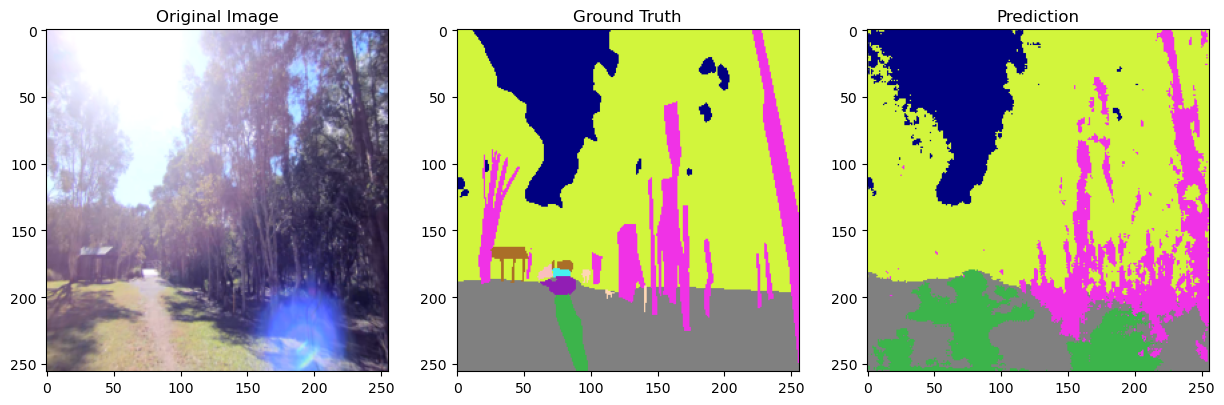

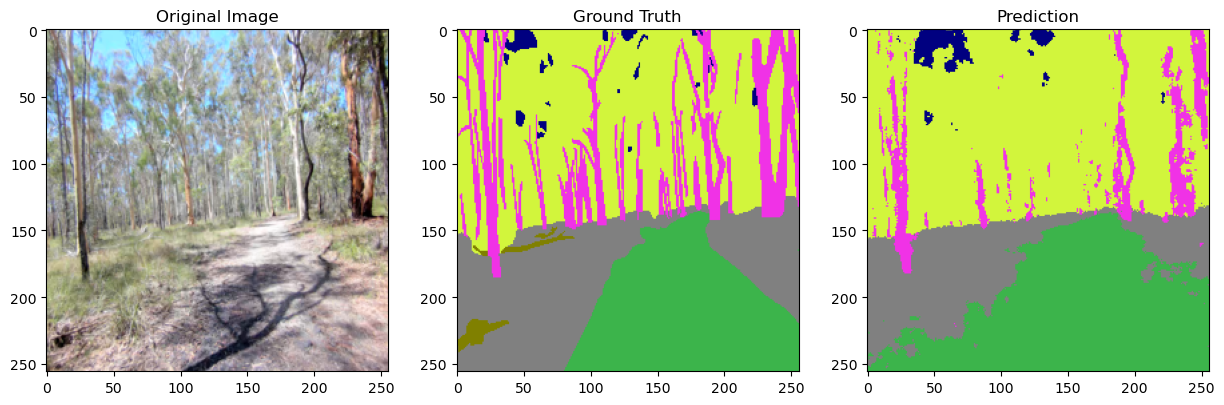

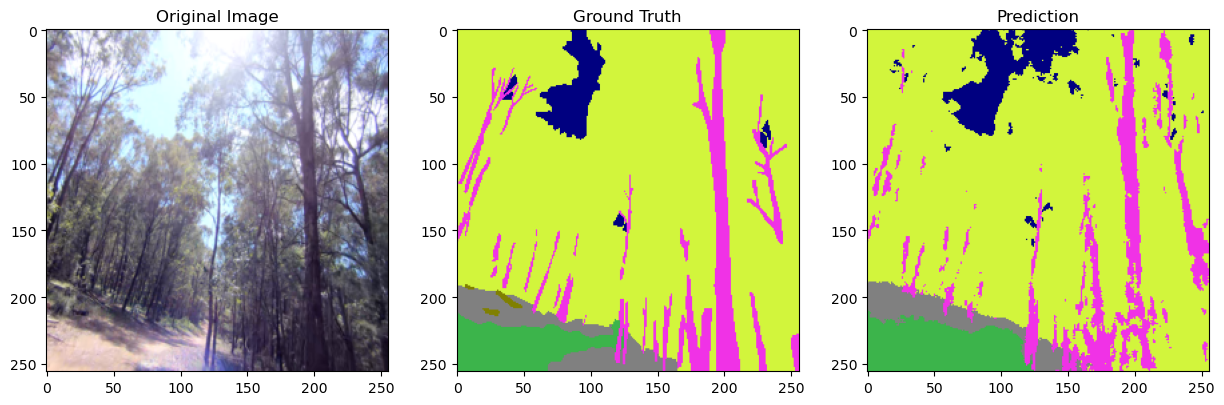

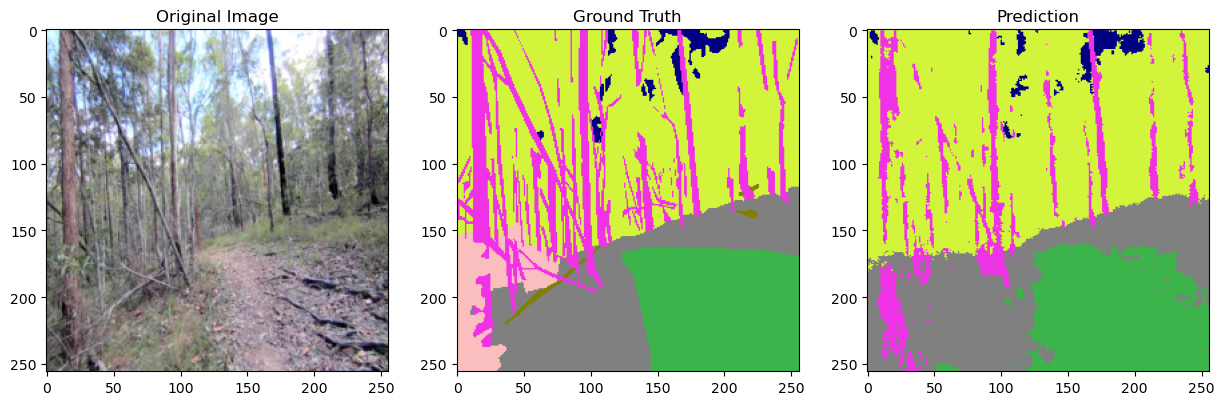

In [6]:
# Define label to RGB function
def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image

def visualize(image, label, prediction, palette):
    _, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[1].imshow(label_to_rgb(label, palette))
    axes[1].set_title('Ground Truth')
    axes[2].imshow(label_to_rgb(prediction, palette))
    axes[2].set_title('Prediction')
    plt.show()

model.eval()
with torch.no_grad():
    for data in test_loader:
        images = data['image'].to(device)
        labels = data['label'].cpu().numpy()
        outputs = model(images).argmax(1).cpu().numpy()
        for i in range(len(images)):
            image = images[i].cpu().numpy().transpose(1, 2, 0)
            label = labels[i]
            prediction = outputs[i]
            visualize(image, label, prediction, METAINFO['palette'])
        break